In [ ]:
!pip install tensorflow

In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.3.1'

In [3]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [16]:
??tf.keras.preprocessing.image_dataset_from_directory

In [18]:
import os
os.listdir(data)

['without_mask', 'with_mask']

In [17]:
data = "../data/"

In [5]:
train_ds = image_dataset_from_directory(directory=data, labels="inferred",
                                                      class_names=['with_mask', 'without_mask'],
                                                      batch_size=16,
                                                      seed=42,
                                                      image_size=(128,128),
                                                      validation_split=0.2,
                                                      subset="training")

Found 1376 files belonging to 2 classes.
Using 1101 files for training.


In [6]:
val_ds = image_dataset_from_directory(directory=data, labels="inferred",
                                                      class_names=['with_mask', 'without_mask'],
                                                      batch_size=16,
                                                      seed=42,
                                                      image_size=(128,128),
                                                      validation_split=0.2,
                                                      subset="validation")

Found 1376 files belonging to 2 classes.
Using 275 files for validation.


# Visualizons la donnée

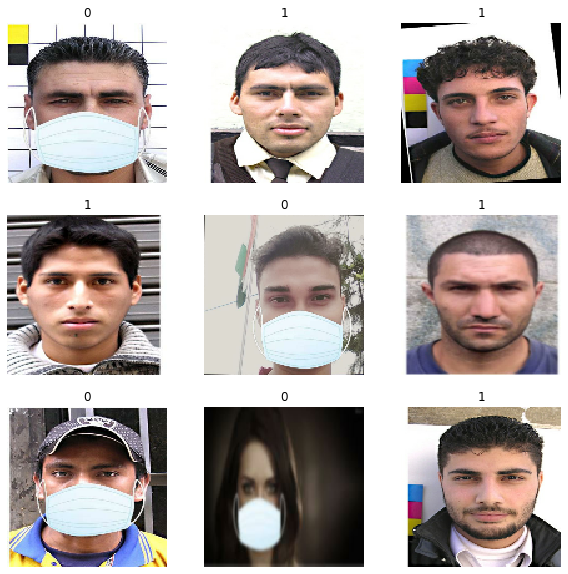

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(int(labels[i]))
        plt.axis('off')

In [8]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

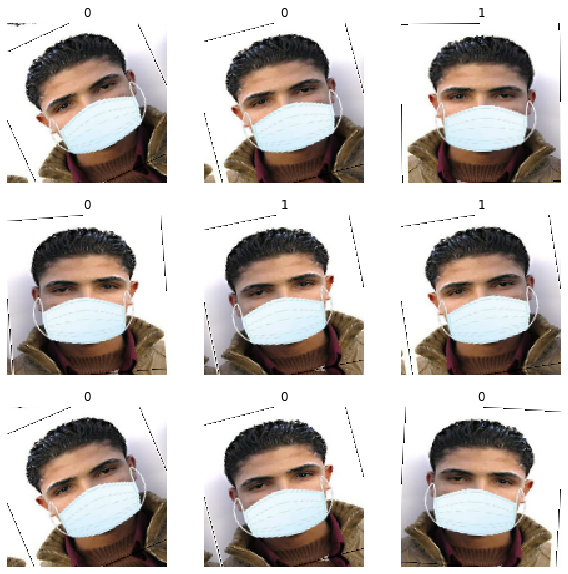

In [9]:
import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[i]))
        plt.axis("off")

# Créons un modèle

In [11]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(128, 128, 3),
    include_top=False, # Do not include the ImageNet classifier at the top.
)  

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(128, 128, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be normalized
# from (0, 255) to a range (-1., +1.), the normalization layer
# does the following, outputs = (inputs - mean) / sqrt(var)
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
# Scale inputs to [-1, +1]
x = norm_layer(x)
norm_layer.set_weights([mean, var])

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 128, 128, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 128, 128, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 4, 4, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                

# Entrainement

In [12]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 1
model.fit(train_ds, epochs=epochs, validation_data=val_ds)

69/69 [==============================] - 36s 527ms/step - loss: 0.2035 - binary_accuracy: 0.9183 - val_loss: 0.0693 - val_binary_accuracy: 0.9855


# Fine tuning

In [14]:
base_model.trainable = True
model.summary()


model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 2
model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 128, 128, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 128, 128, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 4, 4, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                

In [20]:
model.save('model.h5')

# Predictions

In [21]:
mask_detection_model = tf.keras.models.load_model('model.h5')

In [24]:
def detect_mask(filepath):
    img = keras.preprocessing.image.load_img(filepath, target_size=(128,128))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    score = tf.keras.activations.sigmoid(model.predict(img_array)[0].item())
    prob =  1-score
    print(prob)
    if prob <= 0.5:
        return "Pourquoi tu ne portes pas ton masque ?"
    else:
        return "Tu as porté un masque. Continue comme ca!!!"

In [25]:
detect_mask('mask.jpg')

tf.Tensor(0.98493147, shape=(), dtype=float32)


'Tu as porté un masque. Continue comme ca!!!'